In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
max_cars_loc_1 = 20
max_cars_loc_2 = 20
mean_rental_requests_loc_1 = 3
mean_rental_requests_loc_2 = 4
rent_reward_per_car = 10
mean_cars_returned_loc_1 = 3
mean_cars_returned_loc_2 = 2
gamma = 0.9
move_cost_per_car = 3
max_cars_move_per_day = 5
THRESHOLD = 1e-4
parking_cost = 4
max_parking_loc_1 = 10
max_parking_loc_2 = 10

In [3]:
poisson_memo = {}
def poisson_probability(x, LAMBDA):
    key = str(x) + "_" + str(LAMBDA)
    if key not in poisson_memo:
        poisson_memo[key] = poisson.pmf(x, LAMBDA)
    return poisson_memo[key]
    

In [4]:
def perform_action(s, a, v):
    Gt = 0.0
    num_cars_loc_1_after_moving = min(s[0]-a, max_cars_loc_1)    
    num_cars_loc_2_after_moving = min(s[1]+a, max_cars_loc_2)
    
    for num_rental_requests_loc_1 in range(11):
        for num_rental_requests_loc_2 in range(11):  
            prob_rental_requests = poisson_probability(num_rental_requests_loc_1, mean_rental_requests_loc_1) * poisson_probability(num_rental_requests_loc_2, mean_rental_requests_loc_2)
            
            num_cars_presently_at_loc_1 = num_cars_loc_1_after_moving
            num_cars_presently_at_loc_2 = num_cars_loc_2_after_moving
            
            valid_rental_requests_loc_1 = min(num_cars_loc_1_after_moving, num_rental_requests_loc_1)
            valid_rental_requests_loc_2 = min(num_cars_loc_2_after_moving, num_rental_requests_loc_2)
            
            r = (valid_rental_requests_loc_1 + valid_rental_requests_loc_2) * rent_reward_per_car
            
            num_cars_presently_at_loc_1 = num_cars_presently_at_loc_1 - valid_rental_requests_loc_1            
            num_cars_presently_at_loc_2 = num_cars_presently_at_loc_2- valid_rental_requests_loc_2
            
            for num_cars_returned_loc_1 in range(10):
                for num_cars_returned_loc_2 in range(10):
                    r_ = r
                    prob_car_returns = poisson_probability(num_cars_returned_loc_1, mean_cars_returned_loc_1) * poisson_probability(num_cars_returned_loc_2, mean_cars_returned_loc_2)
                    num_cars_presently_at_loc_1 = min(num_cars_presently_at_loc_1 + num_cars_returned_loc_1, max_cars_loc_1)
                    num_cars_presently_at_loc_2 = min(num_cars_presently_at_loc_2 + num_cars_returned_loc_2, max_cars_loc_2)
                    if num_cars_presently_at_loc_1 > max_parking_loc_1:
                        r_ -= parking_cost
                    if num_cars_presently_at_loc_2 > max_parking_loc_2:
                        r_ -= parking_cost
                    p = prob_rental_requests * prob_car_returns
                    Gt += p * (r_ + gamma * v[num_cars_presently_at_loc_1, num_cars_presently_at_loc_2])
            
    if a > 0:
        Gt -= move_cost_per_car * (a-1)
    else:
        Gt -= move_cost_per_car * (-a)
    return Gt             
                    


In [5]:
v = np.zeros((max_cars_loc_1 + 1, max_cars_loc_2 + 1))
policy = np.zeros(v.shape, dtype=np.int)
actions = np.arange(-max_cars_move_per_day, max_cars_move_per_day + 1)

iteration_policies = []

iteration_1 = 0

def policy_evaluation(policy, v):
    v_ = v.copy()
    for i in range(max_cars_loc_1 + 1):
        for j in range(max_cars_loc_2 + 1):
            s = np.array([i, j])
            a = policy[i, j]
            v_[i, j] = perform_action(s, a, v_)
    return v_

def policy_improvement(policy, v):
    policy_ = policy.copy()
    for i in range(max_cars_loc_1 + 1):
        for j in range(max_cars_loc_2 + 1):
            s = np.array([i, j])
            values_per_action = []
            for a in actions:
                if -j <= a <= i:
                    values_per_action.append(perform_action(s, a, v))
                else:
                    values_per_action.append(-np.inf)
            policy_[i, j] = actions[np.argmax(values_per_action)]
    return policy_
            
while True:
    iteration_2 = 0
    while True:
        v_ = policy_evaluation(policy, v)
        difference = np.abs(v_ - v).max()
        print("Iteration: ", iteration_2, " Difference :", difference)
        if difference < THRESHOLD:
            v = v_
            break
        v = v_
        iteration_2 += 1

    stable = True
    policy_ = policy_improvement(policy, v)
            
    if stable and np.any(policy_ != policy):
        stable = False
    print("Iteration: ", iteration_1, ' policy stable {}'.format(stable))
    iteration_policies.append(policy)
    iteration_1 += 1
    policy = policy_
    if stable:
        break


Iteration:  0  Difference : 176.1049769346587
Iteration:  1  Difference : 122.34350804723772
Iteration:  2  Difference : 84.03466059759634
Iteration:  3  Difference : 65.58553278612067
Iteration:  4  Difference : 50.517603344768986
Iteration:  5  Difference : 38.05297823396967
Iteration:  6  Difference : 29.293332663288822
Iteration:  7  Difference : 25.56383305046515
Iteration:  8  Difference : 22.189466127158596
Iteration:  9  Difference : 19.188365951596893
Iteration:  10  Difference : 16.547892449395306
Iteration:  11  Difference : 14.241419432430916
Iteration:  12  Difference : 12.236853247354645
Iteration:  13  Difference : 10.501045055984719
Iteration:  14  Difference : 9.00206296353781
Iteration:  15  Difference : 7.710302657424961
Iteration:  16  Difference : 6.5989503887079195
Iteration:  17  Difference : 5.644083816439661
Iteration:  18  Difference : 4.824576133471794
Iteration:  19  Difference : 4.121900770735351
Iteration:  20  Difference : 3.519893395967074
Iteration:  21

Iteration:  12  Difference : 0.0697757872860052
Iteration:  13  Difference : 0.05973041014607361
Iteration:  14  Difference : 0.05110949388944164
Iteration:  15  Difference : 0.043722963525453906
Iteration:  16  Difference : 0.03739944538654072
Iteration:  17  Difference : 0.03198840031751615
Iteration:  18  Difference : 0.02735927743862021
Iteration:  19  Difference : 0.023399599881372524
Iteration:  20  Difference : 0.020012793450860045
Iteration:  21  Difference : 0.0171160881996002
Iteration:  22  Difference : 0.01463861389441945
Iteration:  23  Difference : 0.012519720851400962
Iteration:  24  Difference : 0.01070752064589442
Iteration:  25  Difference : 0.009157627325009798
Iteration:  26  Difference : 0.00783207582679779
Iteration:  27  Difference : 0.006698394637055571
Iteration:  28  Difference : 0.0057288115733058476
Iteration:  29  Difference : 0.004899574026637765
Iteration:  30  Difference : 0.0041903673483716375
Iteration:  31  Difference : 0.0035838173162119347
Iteration

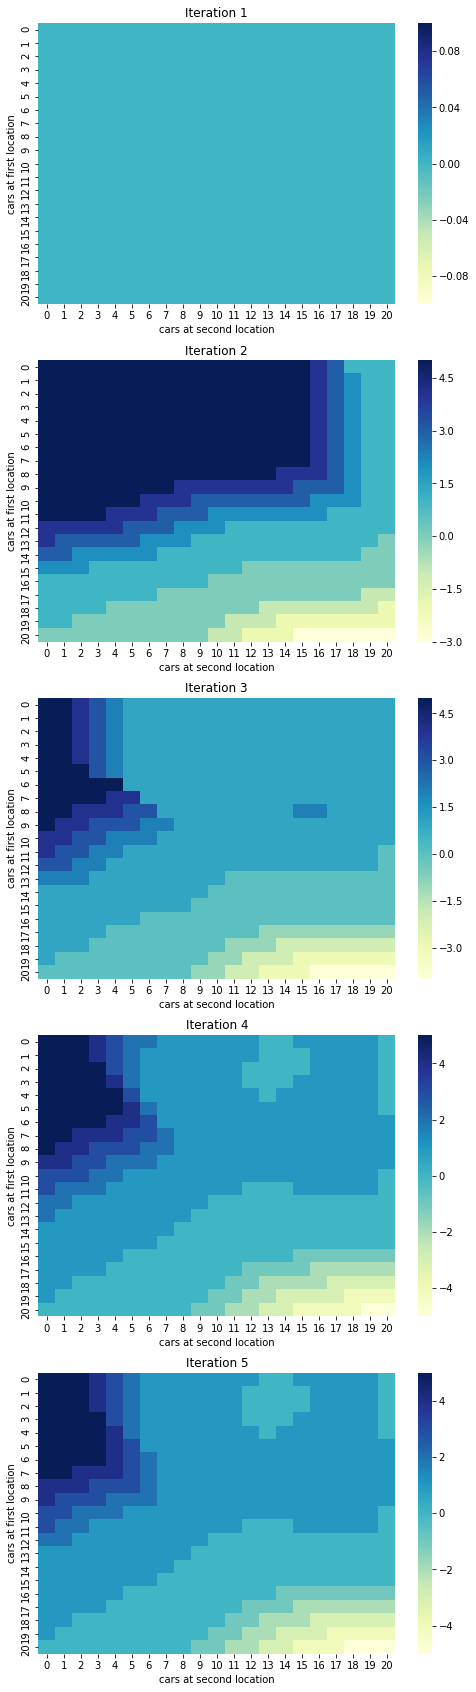

In [6]:
_, axes = plt.subplots(len(iteration_policies), 1, figsize=(8, (len(iteration_policies)+1) * 5))

for i in range(len(iteration_policies)):
    axes[i].set_title("Iteration "+str(i+1))
    sns.heatmap(np.flipud(iteration_policies[i]), cmap="YlGnBu", ax=axes[i])
    axes[i].set_xlabel("cars at second location")
    axes[i].set_ylabel("cars at first location")
plt.show()
plt.close("all")

In [7]:
print(np.flipud(policy))

[[ 5  5  5  4  3  2  1  1  1  1  1  1  1  0  0  1  1  1  1  1  0]
 [ 5  5  5  4  3  2  1  1  1  1  1  1  0  0  0  0  1  1  1  1  0]
 [ 5  5  5  4  3  2  1  1  1  1  1  1  0  0  0  0  1  1  1  1  0]
 [ 5  5  5  5  3  2  1  1  1  1  1  1  0  0  0  1  1  1  1  1  0]
 [ 5  5  5  5  4  2  1  1  1  1  1  1  1  0  1  1  1  1  1  1  0]
 [ 5  5  5  5  4  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 5  5  5  5  4  3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 5  5  4  4  4  3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 4  4  4  3  3  3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 4  3  3  3  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 3  3  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 3  2  2  1  1  1  1  1  1  1  1  1  0  0  0  1  1  1  1  1  0]
 [ 2  2  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1